In [12]:
from __future__ import absolute_import, division, print_function

import os
import sys
import glob
import argparse
import numpy as np
import PIL.Image as pil
import matplotlib as mpl
import matplotlib.cm as cm
from PIL import Image, ImageChops

import torch
from torchvision import transforms, datasets

import networks
from layers import disp_to_depth

# device = ("cuda" if torch.cuda.is_available else "cpu")
device = "cpu"

In [6]:
def test_simple(image_path, model_path, ext):
    """Function to predict for a single image or folder of images
    """
    print("-> Loading model from ", model_path)
    encoder_path = os.path.join(model_path, "encoder.pth")
    depth_decoder_path = os.path.join(model_path, "depth.pth")

    # LOADING PRETRAINED MODEL
    print("   Loading pretrained encoder")
    encoder = networks.ResnetEncoder(18, False)
    loaded_dict_enc = torch.load(encoder_path, map_location=device)

    # extract the height and width of image that this model was trained with
    feed_height = loaded_dict_enc['height']
    feed_width = loaded_dict_enc['width']
    filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
    encoder.load_state_dict(filtered_dict_enc)
    encoder.to(device)
    encoder.eval()

    print("   Loading pretrained decoder")
    depth_decoder = networks.DepthDecoder(
        num_ch_enc=encoder.num_ch_enc, scales=range(4))

    loaded_dict = torch.load(depth_decoder_path, map_location=device)
    depth_decoder.load_state_dict(loaded_dict)

    depth_decoder.to(device)
    depth_decoder.eval()

    # FINDING INPUT IMAGES
    if os.path.isfile(image_path):
        # Only testing on a single image
        paths = [image_path]
        output_directory = os.path.dirname(image_path)
    elif os.path.isdir(image_path):
        # Searching folder for images
        paths = glob.glob(os.path.join(image_path, '*.{}'.format(ext)))
        output_directory = image_path
    else:
        raise Exception("Can not find image_path: {}".format(image_path))

    print("-> Predicting on {:d} test images".format(len(paths)))

    # PREDICTING ON EACH IMAGE IN TURN
    with torch.no_grad():
        for idx, image_path in enumerate(paths):

            if image_path.endswith("_disp.jpg"):
                # don't try to predict disparity for a disparity image!
                continue

            # Load image and preprocess
            input_image = pil.open(image_path).convert('RGB')
            original_width, original_height = input_image.size
            input_image = input_image.resize((feed_width, feed_height), pil.LANCZOS)
            input_image = transforms.ToTensor()(input_image).unsqueeze(0)

            # PREDICTION
            input_image = input_image.to(device)
            features = encoder(input_image)
            outputs = depth_decoder(features)

            disp = outputs[("disp", 0)]
            disp_resized = torch.nn.functional.interpolate(
                disp, (original_height, original_width), mode="bilinear", align_corners=False)

            # Saving numpy file
            output_name = os.path.splitext(os.path.basename(image_path))[0]
            name_dest_npy = os.path.join(output_directory, "{}_disp.npy".format(output_name))
            scaled_disp, _ = disp_to_depth(disp, 0.1, 100)
            np.save(name_dest_npy, scaled_disp.cpu().numpy())

            # Saving colormapped depth image
            disp_resized_np = disp_resized.squeeze().cpu().numpy()
            vmax = np.percentile(disp_resized_np, 95)
            normalizer = mpl.colors.Normalize(vmin=disp_resized_np.min(), vmax=vmax)
            mapper = cm.ScalarMappable(norm=normalizer, cmap='magma')
            colormapped_im = (mapper.to_rgba(disp_resized_np)[:, :, :3] * 255).astype(np.uint8)
            im = pil.fromarray(colormapped_im)

            name_dest_im = os.path.join(output_directory, "{}_disp.jpeg".format(output_name))
            im.save(name_dest_im)

            print("   Processed {:d} of {:d} images - saved prediction to {}".format(
                idx + 1, len(paths), name_dest_im))

    print('-> Done!')

In [15]:
result_imgpath = '/home/alexander/monodepth_simpletests/0000000049_disp.jpeg'
result_depth = '/home/alexander/monodepth_simpletests/0000000049_disp.npy'

## Results after 1 epoch of training

-> Loading model from  /home/alexander/tmp/mono_model_nyu/models/weights_0
   Loading pretrained encoder
   Loading pretrained decoder
-> Predicting on 1 test images
   Processed 1 of 1 images - saved prediction to /home/alexander/monodepth_simpletests/0000000049_disp.jpeg
-> Done!
(1, 1, 256, 320)


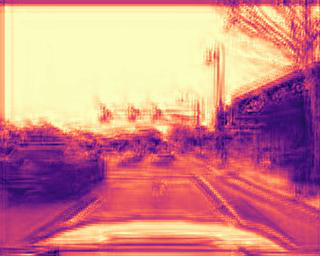

In [36]:
image_path = '/home/alexander/monodepth_simpletests/0000000049.jpg'
model_path = '/home/alexander/tmp/mono_model_nyu/models/weights_0'
ext = 'jpg'
test_simple(image_path, model_path, ext)

depth_img_0 = Image.open(result_imgpath)
depthmap_0 = np.load(result_depth)

print(depthmap_0.shape)
depth_img_0

## Results after 2 epochs of training

-> Loading model from  /home/alexander/tmp/mono_model_nyu/models/weights_1
   Loading pretrained encoder
   Loading pretrained decoder
-> Predicting on 1 test images
   Processed 1 of 1 images - saved prediction to /home/alexander/monodepth_simpletests/0000000049_disp.jpeg
-> Done!
(1, 1, 256, 320)


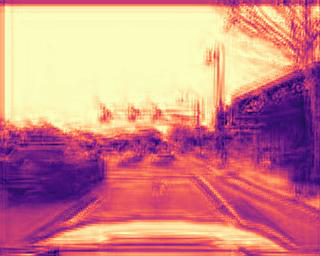

In [37]:
image_path = '/home/alexander/monodepth_simpletests/0000000049.jpg'
model_path = '/home/alexander/tmp/mono_model_nyu/models/weights_1'
ext = 'jpg'
test_simple(image_path, model_path, ext)

depth_img_1 = Image.open(result_imgpath)
depthmap_1 = np.load(result_depth)

print(depthmap_1.shape)
depth_img_1

## Results after 3 epochs of training

-> Loading model from  /home/alexander/tmp/mono_model_nyu/models/weights_2
   Loading pretrained encoder
   Loading pretrained decoder
-> Predicting on 1 test images
   Processed 1 of 1 images - saved prediction to /home/alexander/monodepth_simpletests/0000000049_disp.jpeg
-> Done!
(1, 1, 256, 320)


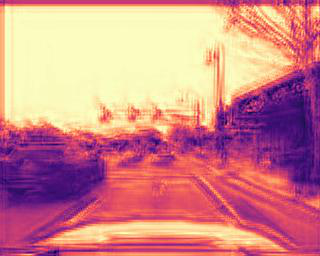

In [38]:
image_path = '/home/alexander/monodepth_simpletests/0000000049.jpg'
model_path = '/home/alexander/tmp/mono_model_nyu/models/weights_2'
ext = 'jpg'
test_simple(image_path, model_path, ext)

depth_img_2 = Image.open(result_imgpath)
depthmap_2 = np.load(result_depth)

print(depthmap_2.shape)
depth_img_2

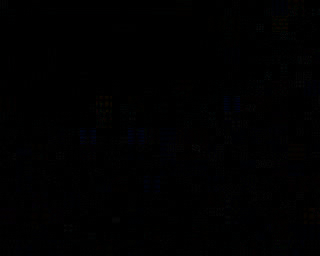

In [39]:
ImageChops.difference(depth_img_1, depth_img_2)

In [49]:
depthmap_0 - depthmap_2

array([[[[ 7.0714951e-04,  1.0004044e-03,  1.2898445e-03, ...,
           7.4434280e-04,  1.6880035e-04,  5.9175491e-04],
         [ 6.6995621e-04,  9.0360641e-04,  1.1749268e-03, ...,
           6.0033798e-04,  3.5762787e-04,  7.9774857e-04],
         [ 2.8514862e-04,  5.0878525e-04,  8.3732605e-04, ...,
           4.1294098e-04, -2.8944016e-04,  2.9563904e-04],
         ...,
         [-6.0176849e-04, -6.9904327e-04, -1.0237694e-03, ...,
          -1.2769699e-03, -1.8153191e-03, -1.2969971e-03],
         [ 4.4822693e-05, -9.0599060e-05, -3.6525726e-04, ...,
          -7.8964233e-04, -8.1014633e-04, -4.7540665e-04],
         [ 2.0217896e-04,  2.0980835e-05, -3.2091141e-04, ...,
          -1.0137558e-03, -1.0499954e-03, -3.5524368e-04]]]],
      dtype=float32)

-> Loading model from  /home/alexander/tmp/mono_model_nyu/models/weights_2
   Loading pretrained encoder
   Loading pretrained decoder
-> Predicting on 1 test images
   Processed 1 of 1 images - saved prediction to /home/alexander/monodepth_simpletests/0000000049_disp.jpeg
-> Done!
(1, 1, 256, 320)


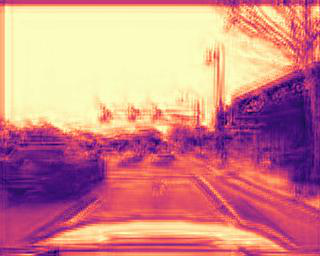

In [100]:
image_path = '/home/alexander/monodepth_simpletests/0000000049.jpg'
model_path = '/home/alexander/tmp/mono_model_nyu/models/weights_2'
ext = 'jpg'
test_simple(image_path, model_path, ext)

depth_img_3 = Image.open(result_imgpath)
depthmap_3 = np.load(result_depth)

print(depthmap_3.shape)
depth_img_3

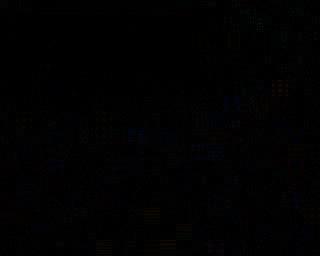

In [106]:
ImageChops.difference(depth_img_0, depth_img_3)

In [111]:
depthmap_3[0][0][250]

array([4.516876 , 4.5947695, 4.605837 , 4.620372 , 4.616185 , 4.6129804,
       4.620428 , 4.62728  , 4.620305 , 4.5968843, 4.5930095, 4.6142015,
       4.610609 , 4.608415 , 4.5911045, 4.619897 , 4.616856 , 4.6435485,
       4.645581 , 4.668167 , 4.683687 , 4.684777 , 4.677762 , 4.683493 ,
       4.676354 , 4.65963  , 4.6508813, 4.6702213, 4.688712 , 4.7122464,
       4.7390985, 4.7232504, 4.766548 , 4.730492 , 4.714142 , 4.697923 ,
       4.686    , 4.6691384, 4.6244593, 4.6628346, 4.666699 , 4.692162 ,
       4.680889 , 4.716013 , 4.721332 , 4.7248516, 4.7499757, 4.7181745,
       4.6805153, 4.619445 , 4.6078167, 4.566715 , 4.5642643, 4.5830946,
       4.503216 , 4.424253 , 4.457373 , 4.4413276, 4.4046407, 4.521592 ,
       4.5440135, 4.524742 , 4.5387745, 4.522284 , 4.5391903, 4.5296288,
       4.514128 , 4.5357747, 4.5486126, 4.5334187, 4.528092 , 4.5174017,
       4.519381 , 4.522006 , 4.5326824, 4.5217433, 4.528116 , 4.5225973,
       4.51817  , 4.513865 , 4.5273833, 4.5228953, 

-> Loading model from  /home/alexander/tmp/mono_model_nyu/models/weights_3
   Loading pretrained encoder
   Loading pretrained decoder
-> Predicting on 1 test images
   Processed 1 of 1 images - saved prediction to /home/alexander/monodepth_simpletests/0000000049_disp.jpeg
-> Done!
(1, 1, 256, 320)


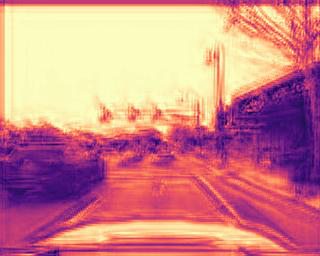

In [112]:
image_path = '/home/alexander/monodepth_simpletests/0000000049.jpg'
model_path = '/home/alexander/tmp/mono_model_nyu/models/weights_3'
ext = 'jpg'
test_simple(image_path, model_path, ext)

depth_img_4 = Image.open(result_imgpath)
depthmap_4 = np.load(result_depth)

print(depthmap_4.shape)
depth_img_4

In [121]:
depthmap_4

array([[[[4.7061896, 4.673392 , 4.650324 , ..., 4.816659 , 4.8170075,
          4.6503587],
         [4.5973706, 4.605854 , 4.66879  , ..., 4.777109 , 4.820484 ,
          4.6469145],
         [4.5720296, 4.5917993, 4.5946474, ..., 4.7423296, 4.7914886,
          4.6320624],
         ...,
         [4.574064 , 4.6162324, 4.6031036, ..., 4.6519427, 4.6440253,
          4.6482754],
         [4.5829897, 4.5824194, 4.642979 , ..., 4.7905474, 4.766805 ,
          4.72298  ],
         [4.6452975, 4.629116 , 4.6748085, ..., 4.767085 , 4.786976 ,
          4.702083 ]]]], dtype=float32)

-> Loading model from  /home/alexander/tmp/mono_model_nyu/models/weights_0
   Loading pretrained encoder
   Loading pretrained decoder
-> Predicting on 1 test images
   Processed 1 of 1 images - saved prediction to /home/alexander/monodepth_simpletests/0000000049_disp.jpeg
-> Done!
(1, 1, 256, 320)


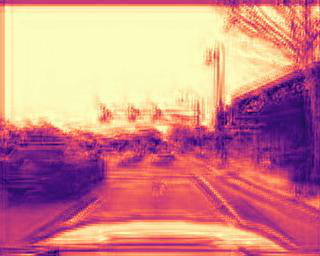

In [132]:
image_path = '/home/alexander/monodepth_simpletests/0000000049.jpg'
model_path = '/home/alexander/tmp/mono_model_nyu/models/weights_0'
ext = 'jpg'
test_simple(image_path, model_path, ext)

depth_img_5 = Image.open(result_imgpath)
depthmap_5 = np.load(result_depth)

print(depthmap_5.shape)
depth_img_5

In [131]:
depthmap_5[0][0][200]

array([4.5469646, 4.5467887, 4.5224814, 4.5516567, 4.5269313, 4.50642  ,
       4.523466 , 4.49923  , 4.478    , 4.446003 , 4.4467673, 4.434011 ,
       4.4436893, 4.4469047, 4.4499946, 4.443875 , 4.440671 , 4.4497876,
       4.4638953, 4.4676585, 4.48167  , 4.4646416, 4.458079 , 4.455391 ,
       4.4486837, 4.47644  , 4.480279 , 4.463095 , 4.456778 , 4.444394 ,
       4.442418 , 4.458041 , 4.464269 , 4.4686055, 4.4716086, 4.472964 ,
       4.4711504, 4.46666  , 4.4673133, 4.4637203, 4.462411 , 4.45625  ,
       4.460244 , 4.456543 , 4.4493613, 4.4442   , 4.4450674, 4.444731 ,
       4.4394403, 4.438011 , 4.438655 , 4.4443   , 4.448399 , 4.44745  ,
       4.4534607, 4.4574027, 4.4689126, 4.4648767, 4.471604 , 4.4718328,
       4.470291 , 4.471748 , 4.4759283, 4.475934 , 4.493637 , 4.500217 ,
       4.470501 , 4.488866 , 4.4693303, 4.49041  , 4.516074 , 4.5276337,
       4.5406466, 4.5104733, 4.5276246, 4.51632  , 4.511507 , 4.5273294,
       4.5261827, 4.523803 , 4.534495 , 4.543362 , 